# Case study: Path Integration
### We use RatInABox to built a network capable of learning to path integrate in 1D using local learning rules

This work is closely related to the work done by [Vafidis et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.03.12.435035v1). Although the specific details of our learning rules, parameter settings and architecture are all slightly different we do not claim this work to be novel. Rather include it as a demonstraion of what is possible (even "easy") to study using `RatInABox`.

To avoid rewritting their paper we give only sparse, key details here. If you intend to make perfect sense of , or even build upon this example, we recommend reading the 
Vafidis et al. (2021) first, and (optionally but highly recommended too) McNaughton et al. (2006). If you don't intend to do this, this section, and the code below, can still be read, run and referenced as a tutorial for `RatInABox`. 

For now we will briefly describe the problem of path integration and our approach for how to solve it in 1D using `RatInABox`.

### Path integration with ring attractors and velocity inputs
Animals need to maintain an encoding of their state in the world even in the absence of sensory input. For one dimensional variables (such as the animals head direction, or location along a linear track) it is often assumed this is done using a ring-attractor network. Ring attractors are a type of continuous attractor neural network (CANN). 

In a ring attractor network, the neurons are arranged in a 1D ring. A bump of activity is stabilised by local-excitatory and long-range inhibitatory weights between neighbouring cells (sometime long range inhibition is replaced with global inhibition as in Vafidis et al.). 

Inputs from cells encoding the animals velocity can "push" the bump activity around the ring in correspondence with the position of the animal. For each ring attractor neuron, suppose there exists a left and right "conjunctive velocity neuron" (conjuctive because the velocity neuron being active is contingent on its corresponding bump attractor neuron being active, this is a small detail your intuitive understanding can probably afford to ignore) which connects assymetrically to the bump attractor neurons. Specifically the left conjuctive velocity cell corresponding to ring attractor cell $i$ might connect in an excitatory manner to cells to the left of cell $i$ and in an inhibitory manner to cells to the right. This way when the animal moves left the velocity neuron becomes active and excites neurons on the left of the bump and inhibits thos on the right, thus pushes the bump leftwards. 

A lot of work in bump attractors and path integration relates to maintaining knowledge of head direction (a ring manifold of neurons, manifesting topologically as a ring within the brain, has been found in drosophila and linked to path integration of head direction (Kim et al. 2017)). However it is not necesasry for the neurons arrangement in physical space to correspond with the manifold (e.g a 1D ring) their activity lies on. This is the running hyptohesis for the role of entorhinal cortex as a neural substrate for path integration and the "cognitive map". We recommend McNaughton (2006) for a good summary of path integration as applied to hippocampus/entorhinal cortex. Specifically the activity profile of grid cells is though to lie on a torodial (torus = 2D equivalent of a 1D ring) manifold. Everything about this system seems pretty well set up to perform path integration, there are even velocity-conjuctive grod cells which would do the pushing of the bump. 

<img src="../images/pathint.gif" width="700" align="center">

 ### Our approach

 The key problem identified by Vafidis et al. is that the weights (local excitation and long range inhibition for the recurrent connection of the ring-attractor and the asymmetric connectivity profile from the conjunctive velocity cells) need to be fine tuned. It is unliekly these connectivety profiles are hard coded by evolution and, for reasons of flexibility, it would be better (and more flexible) if instead they could be *learned* and better still if the learning rule can be local and Hebbian. 

 To do this we define a classes of `Neurons` called `PyramidalNeurons`. Each pyramidal neuron has three compartments (two dendritic and one somatic). The first (basal) dendritic compartment recieves bottom-up sensory input from a set of `PlaceCells` from which they are driven in a one-to-one manner. This will act as the target signal, i.e. a localised bump of activity correponding to the nearby place cells currently active.. A second compartment recieves top-down input from the conjunctive velocity cells and recurrent inputs. Which dendritic compartment drives the soma can be adaptively controlled by a parameter we call `theta`. 
 
 The local hebbian learning rule we used is based on a well studied class of neuronal learning rules where the dendritic compartments attempts to adjust their weights to match the somatic compartment firing rate. This has been term "dendritic prediction of somatic activity" and, if the dendritc voltage function is linear, looks like a voltage thresholded Hebbian learning rule (see Urbanczik and Senn (2014)).

 The necessary equations are as follows (note a more biophysically details version of our slimmed down learning rule is implememnted in Vafidis etal. so please see tehre for more details).  

 $$\mathsf{V}^{\textrm{basal}} = \sum_{i}\mathsf{w}^{\textrm{basal}}_{i}\mathsf{I}_{i}^{\textrm{basal}}$$

  $$\mathsf{V}^{\textrm{apical}} = \sum_{i}\mathsf{w}^{\textrm{apical}}_{i}\mathsf{I}_{i}^{\textrm{apical}}$$

 where $\mathsf{I}_{i}$ is the unitless input from the layer feeding into theis dendritic compartment (just the firing rate of that layer). ${I}_{i}^{\textrm{basal}} = \{ {I}_{i}^{\textrm{place cells}} \}$ and ${I}_{i}^{\textrm{apical}} = \{ {I}_{i}^{\textrm{ring attractor}}, {I}_{i}^{\textrm{conjuctive velocity cells}} \}$. 

 $$\frac{d\mathsf{w_{i}^{\textrm{apical}}}(t)}{dt} \propto \big( \mathsf{V}^{\textrm{soma}} - \mathsf{V}^{\textrm{basal}}\big)\mathsf{I}_{i}^{\textrm{basal}} $$

 where the somatic voltage is given simply by 

 $$\mathsf{V}^{\textrm{soma}} = (1-\theta(t))\mathsf{V}^{\textrm{basal}} + \theta(t)\mathsf{V}^{\textrm{apical}}$$

 Typically we set theta to be oscillatory. The soma rapidly oscillates between being driven by the top-down inputs from its apical dendritic compartment and bottom-up inputs from its basal compartment. 

 <img src="../images/pathint_network.png" width="750" align="center"> 

Green weights are plastic, trained via the local Hebbian learning rule, while blue weights are fixed to sensible values.  

Note the agent, the environment, and three of the four cell layers are all taken directly from `RatInABox`. Only one bespoke `Neurons` cell class need to be defined (this is the `PyramidalNeuron` layer which will become the ring attractor. Infact we chooose to define the dendritic compartments of each pyramidal cell as a `Neurons` classes too)

Other relevant details include: 

* The conjuctive velocity neurons each recieve an input from one and only one ring attractor cell as well as a velocity neuron (left or right, depending on which population it resides in). This fixed weight from the ring attractor input is tuned such that when the ring attractor neuron fires fully (i.e. the bump is centred on its part of the ring) the activity in the conjunctive cell reaches threshold. Any additional input from the velocity cell now causes activity on this neuron. This means 
* The input to the conjuctive velocity cells from the velocity neurons is scaled such that the full sigmoid activity range is covered over the first two standard deviations of the animals likely speed. 

In [1]:
#Import ratinabox
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *

%load_ext autoreload
%autoreload 2

from tqdm import tqdm

In [2]:
#Leave this as False. 
#For paper/readme production I use a plotting library (tomplotlib) to format and save figures. Without this they will still show but not save. 
if False: 
    import tomplotlib.tomplotlib as tpl
    tpl.figureDirectory = "../figures/"
    tpl.setColorscheme(colorscheme=2)
    save_plots = True
else:
    save_plots = False

### Defining the `PyramidalNeurons` class 

In [6]:
class PyramidalNeurons(Neurons):
    """The PyramidalNeuorn class defines a layer of Neurons() whos firing rates are derived from the firing rates in two DendriticCompartments. They are theta modulated, during early theta phase the apical DendriticCompartment (self.apical_compartment) drives the soma, during late theta phases the basal DendriticCompartment (self.basal_compartment) drives the soma.
     
    Must be initialised with an Agent and a 'params' dictionary. 

    Check that the input layers are all named differently. 
    List of functions: 
        • get_state()
        • update()
        • update_dendritic_compartments()
        • update_weights()
        • plot_loss()
        • plot_rate_map()
    """
    def __init__(self,Agent,params={}):
        """Initialises a layer of pyramidal neurons

        Args:
            Agent (_type_): _description_
            params (dict, optional): _description_. Defaults to {}.
        """        
        default_params = {
            'n':10,
            'name':'PyramidalNeurons',
            #theta params 
            'theta_freq':5,
            'theta_frac':0.5, #-->0 all basal input, -->1 all apical input
        }
        default_params.update(params)
        self.params = default_params
        super().__init__(Agent, self.params)

        self.history['loss']=[]
        self.error=None
         
        self.basal_compartment = DendriticCompartment(self.Agent,
                params={
                    'soma':self,
                    'name':f"{self.name}_basal",
                    'n':self.n,
                    'color':self.color,
        })
        self.apical_compartment = DendriticCompartment(self.Agent,
                params={
                    'soma':self,
                    'name':f"{self.name}_apical",
                    'n':self.n,
                    'color':self.color
        })

    def update(self):
        """Updates the firing rate of the layer. Saves a loss (lpf difference between basal and apical). Also adds noise.
        """        
        super().update() #this sets and saves self.firingrate 

        dt = self.Agent.dt 
        tau_smooth = 10 
        #update a smoothed history of the loss
        fr_b, fr_a = self.basal_compartment.firingrate, self.apical_compartment.firingrate
        error = np.mean(np.abs(fr_b - fr_a))
        if self.Agent.t < 2/self.theta_freq:
            self.error = None
        else:
            # loss_smoothing_timescale = dt
            self.error = (dt / tau_smooth) * error + (
            1 - dt / tau_smooth
            ) * (self.error or error) 
        self.history["loss"].append(self.error)
        return 

    def update_dendritic_compartments(self):
        """Individually updates teh basal and apical firing rates.
        """        
        self.basal_compartment.update()
        self.apical_compartment.update()
        return

    def get_state(self, evaluate_at="last", **kwargs):
        """Returns the firing rate of the soma. This depends on the firing rates of the basal and apical compartments and the current theta phase. By default the theta  is obtained from self.Agent.t but it can be passed manually as an kwarg to override this. 

        theta (or theta_gating) is a number between [0,1] controlling flow of information into soma from the two compartment.s 0 = entirely basal. 1 = entirely apical. Between equals weighted combination. he function theta_gating() takes a time and returns theta.  
        Args:
            evaluate_at (str, optional): 'last','agent','all' or None (in which case pos can be passed directly as a kwarg). Defaults to "last".
        Returns:
            firingrate
        """        
        #theta can be passed in manually as a kwarg. If it isn't ithe time from the agent will be used to get theta. Theta determines how much basal and how much apical this neurons uses. 
        if 'theta' in kwargs:
            theta = kwargs['theta']
        else: 
            theta = theta_gating(t = self.Agent.t,
                                 freq=self.theta_freq,
                                 frac=self.theta_frac)    
        fr_basal, fr_apical = 0, 0
        #these are special cases, no need to even get their fr's if they aren't used
        if theta != 0: fr_apical = self.apical_compartment.get_state(evaluate_at, **kwargs)
        if theta != 1: fr_basal = self.basal_compartment.get_state(evaluate_at, **kwargs)
        firingrate =  (1-theta)*fr_basal + (theta)*fr_apical
        return firingrate
    
    def update_weights(self):
        """Trains the weights, this function actually defined in the dendrite class.
        """        
        if self.Agent.t > 2/self.theta_freq:
            self.basal_compartment.update_weights()
            self.apical_compartment.update_weights()
        return 

    def plot_loss(self, fig=None, ax=None):
        """Plots the loss against time to see if learning working
        """        
        if fig is None and ax is None: 
            fig, ax = plt.subplots(figsize=(1.5, 1.5))
            ylim=0
        else: ylim = ax.get_ylim()[1]
        t = np.array(self.history["t"]) / 60
        loss = self.history["loss"]
        ax.plot(t, loss, color=self.color, label=self.name)
        ax.set_ylim(bottom=0, top=max(ylim, np.nanmax(np.array(loss, dtype=np.float64))))
        ax.set_xlim(left=0)
        ax.legend(frameon=False)
        ax.set_xlabel("Training time / min")
        ax.set_ylabel("Loss")
        return fig, ax
    
    def plot_rate_map(self,route='basal',**kwargs):
        """This is a wrapper function for the general Neuron class function plot_rate_map. It takes the same arguments as Neurons.plot_rate_map() but, in addition, route can be set to basal or apical in which case theta is set correspondingly and teh soma with take its input from downstream or upstream sources entirely. 

        The arguments for the standard plottiong function plot_rate_map() can be passed as usual as kwargs. 

        Args:
            route (str, optional): _description_. Defaults to 'basal'.
        """        
        if route=='basal':theta=0
        elif route=='apical':theta=1
        fig, ax = super().plot_rate_map(**kwargs,theta=theta)
        return fig, ax
    

class DendriticCompartment(Neurons):
    """The DendriticCompartment class defines a layer of Neurons() whos firing rates are an activated linear combination of input layers. This class is a subclass of Neurons() and inherits it properties/plotting functions.  

    Must be initialised with an Agent and a 'params' dictionary. 
    Input params dictionary must  contain a list of input_layers which feed into these Neurons. This list looks like [Neurons1, Neurons2,...] where each is a Neurons() class. 

    Currently supported activations include 'sigmoid' (paramterised by max_fr, min_fr, mid_x, width), 'relu' (gain, threshold) and 'linear' specified with the "activation_params" dictionary in the inout params dictionary. See also activate() for full details. 

    Check that the input layers are all named differently. 
    List of functions: 
        • get_state()
        • add_input()
    """

    def __init__(self, Agent, params={}):
        default_params = {
            "soma":None,
            "activation_params": {
                "activation": "sigmoid",
                "max_fr": 1,
                "min_fr": 0,
                "mid_x": 1,
                "width_x": 2,},
        }
        self.Agent = Agent
        default_params.update(params)
        self.params = default_params
        super().__init__(Agent, self.params)

        self.firingrate_temp = None
        self.firingrate_prime_temp = None
        self.inputs = {}

    def add_input(self, 
                  input_layer,
                  eta = 0.001,
                  w_init = 0.1,
                  L1 = 0.0001,
                  L2 = 0.001,
                  tau_PI = 100e-3):
        """Adds an input layer to the class. Each input layer is stored in a dictionary of self.inputs. Each has an associated matrix of weights which are initialised randomly. 

        Args:
            input_layer (_type_): the layer which feeds into this compartment
            eta: learning rate of the weights 
            w_init: initialisation scale of the weights 
            L1: how much L1 regularisation
            L2: how much L2 regularisation
            tau_PI: smoothing timescale of plasticity induction variable
        """
        name = input_layer.name
        n_in = input_layer.n
        w = np.random.normal(
            loc=0, scale=w_init / np.sqrt(n_in), size=(self.n, n_in)
        )
        I = np.zeros(n_in)
        PI = np.zeros(n_in)
        if name in self.inputs.keys():
            print(
                f"There already exists a layer called {input_layer_name}. Overwriting it now."
            )
        self.inputs[name] = {}
        self.inputs[name]["layer"] = input_layer
        self.inputs[name]["w"] = w
        self.inputs[name]["w_init"] = w.copy()
        self.inputs[name]["I"] = I #input current
        self.inputs[name]["I_temp"] = None #input current
        self.inputs[name]["PI"] = PI #plasticity induction variable
        self.inputs[name]["eta"] = eta 
        self.inputs[name]["L2"] = L2 
        self.inputs[name]["L1"] = L1 
        self.inputs[name]["tau_PI"] = tau_PI

    def get_state(self, evaluate_at="last", **kwargs):
        """Returns the "firing rate" of the dendritic compartment. By default this layer uses the last saved firingrate from its input layers. Alternatively evaluate_at and kwargs can be set to be anything else which will just be passed to the input layer for evaluation. 
        Once the firing rate of the inout layers is established these are multiplied by the weight matrices and then activated to obtain the firing rate of this FeedForwardLayer.

        Args:
            evaluate_at (str, optional). Defaults to 'last'.
        Returns:
            firingrate: array of firing rates 
        """
        if evaluate_at == 'last':
            V = np.zeros(self.n)
        elif evaluate_at == 'all': 
            V = np.zeros((self.n,self.Agent.Environment.flattened_discrete_coords.shape[0]))
        else:
            V = np.zeros((self.n,kwargs['pos'].shape[0]))

        for inputlayer in self.inputs.values():
            w = inputlayer["w"]
            if evaluate_at == "last":
                I = inputlayer["layer"].firingrate
            else:  # kick can down the road let input layer decide how to evaluate the firingrate
                I = inputlayer["layer"].get_state(evaluate_at, **kwargs)
            inputlayer['I_temp'] = I
            V += np.matmul(w, I)
        firingrate = activate(V, other_args=self.activation_params)
        firingrate_prime = activate(V, other_args=self.activation_params, deriv=True)  

        self.firingrate_temp = firingrate
        self.firingrate_prime_temp = firingrate_prime

        return firingrate

    def update(self):
        """Updates firingrate of this compartment and saves it to file
        """        
        self.get_state()
        self.firingrate = self.firingrate_temp.reshape(-1)
        self.firingrate_deriv = self.firingrate_prime_temp.reshape(-1)
        for inputlayer in self.inputs.values():
            inputlayer['I'] = inputlayer['I_temp'].reshape(-1)
        self.save_to_history()
        return
        
    def update_weights(self):
        """Implements the weight update: dendritic prediction of somatic activity. 
        """  
        target = self.soma.firingrate      
        delta = (target - self.firingrate) * (self.firingrate_deriv)
        dt = self.Agent.dt
        for inputlayer in self.inputs.values():
            eta = inputlayer['eta']
            if eta != 0: 
                tau_PI = inputlayer['tau_PI']
                assert (dt / tau_PI) < 0.2
                I = inputlayer['I']
                w = inputlayer['w']
                #first updates plasticity induction variable (smoothed delta error outer product with the input current for this input layer)
                PI_old = inputlayer['PI']
                PI_update = np.outer(delta, I)
                PI_new = (dt / tau_PI) * PI_update + (
                1 - dt / tau_PI) * PI_old
                inputlayer['PI'] = PI_new
                #updates weights
                dw = eta * (PI_new - inputlayer['L2']*w - inputlayer['L1']*np.sign(w)) 
                inputlayer['w'] = w + dw
        return

def theta_gating(t,
                 freq=10,
                 frac=0.5):
        T = 1/freq
        phase = ((t/T) % 1) % 1
        if phase < frac:
            return 1
        elif phase >= frac:
            return 0

### Building the network
This involves initialising the environment, the agent and all of the cells layers shown in the above figure. Then we must set the inputs to each cell layer) and, for those layers where the weights are fixed, set them correctly. 

Basically, the following code amounts to constructing the network shown in the above figure. 

In [7]:
#Initialise the 1D environment 
Env = Environment(params={'dimensionality':'1D',
                          'boundary_conditions':'periodic'})

#Put agent (who will move randomly under the ratinabox Ornstein Uhlenbeck random motion policy) inside the environement
Ag = Agent(Env)
Ag.speed_mean = 0
Ag.speed_std=0.3

n_cells = 50
#Place cells provide the target signal 
PlaceCells_ = PlaceCells(Ag, params={'n':n_cells,
                             'widths':0.1,
                             'name':'PlaceCells'})

#The key neuron class: Ring attractor at the centre of the network made from our bespoke, custom-define PyramidalNeurons class. 
RingAttractor = PyramidalNeurons(Ag,params={'n':n_cells,
                                            'name':'RingAttractor'})

#Velocity cells encode agent velocity
VelocityCells_ = VelocityCells(Ag,params={'name':'VelocityCells'})

#Conjuctive cells 
ConjunctiveCells_left = FeedForwardLayer(Ag,
                    params={'n':n_cells,
                            'name':'ConjunctiveCells_left',
                            })

ConjunctiveCells_right = FeedForwardLayer(Ag,
                    params={'n':n_cells,
                            'name':'ConjunctiveCells_right',
                            })

#Set inputs into ring attractor compartments
#Make their activation functions linear 
#Set the fixed weights from place celles to Ring attractor to be fixed 
RingAttractor.apical_compartment.add_input(RingAttractor)
RingAttractor.apical_compartment.add_input(ConjunctiveCells_left)
RingAttractor.apical_compartment.add_input(ConjunctiveCells_right)
RingAttractor.apical_compartment.activation_params = {"activation": "linear"}

RingAttractor.basal_compartment.add_input(PlaceCells_,eta=0) #eta=0, these are fixed 
RingAttractor.basal_compartment.inputs['PlaceCells']['w'] = np.identity(n_cells)
RingAttractor.basal_compartment.activation_params = {"activation": "linear"}

#Set inputs into the conjuctive cells
#Set the (fixed) weights into the conjunctive cells to be their correct values (identity or just 1's)
ConjunctiveCells_left.add_input(VelocityCells_)
ConjunctiveCells_left.add_input(RingAttractor)
ConjunctiveCells_right.add_input(VelocityCells_)
ConjunctiveCells_right.add_input(RingAttractor)
ConjunctiveCells_left.inputs['VelocityCells']['w'] = np.ones((n_cells,2)) * np.array([1,-1]) #thus left velocity excites these cells and right velocity shuts them off
ConjunctiveCells_right.inputs['VelocityCells']['w'] = np.ones((n_cells,2)) * np.array([-1,1])#thus right velocity excites these cells and rigleftht velocity shuts them off
ConjunctiveCells_left.inputs['RingAttractor']['w'] = np.identity(n_cells)
ConjunctiveCells_right.inputs['RingAttractor']['w'] = np.identity(n_cells)
ConjunctiveCells_left.activation_params={
                                "activation": "sigmoid",
                                "mid_x": 2,
                                "width_x": 2}
ConjunctiveCells_right.activation_params={
                                "activation": "sigmoid",
                                "mid_x": 2,
                                "width_x": 2}

### Train the network

Train it for 20 minutes

In [8]:
for i in tqdm(range(int(20*60/Ag.dt))):
    #update agent
    Ag.update()
    #update firing rates of all the cell layers
    PlaceCells_.update()
    VelocityCells_.update()
    ConjunctiveCells_left.update()
    ConjunctiveCells_right.update()
    RingAttractor.update_dendritic_compartments()
    RingAttractor.update()
    #finally, update the weights
    RingAttractor.update_weights()


100%|██████████| 120000/120000 [00:49<00:00, 2443.54it/s]


### Analysis 
Now training is complete we can see whether it as been successful. 
First we plot the loss. This is a (smoothed) trace of the mean absolute difference bwetween the voltage in the basal compartment (the ground truth) and the voltage in teh apical compartment (the compartment learnign to replicate the ground truth using recurrent and conjuncti ve veloicty inputs). 

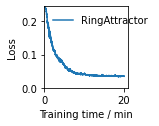

In [7]:
fig, ax = RingAttractor.plot_loss()

if save_plots == True: 
    tpl.saveFigure(fig,"PI_loss")

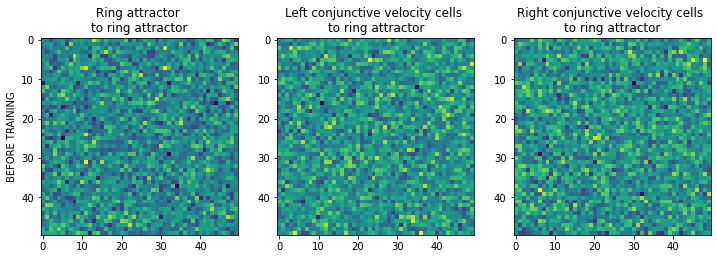

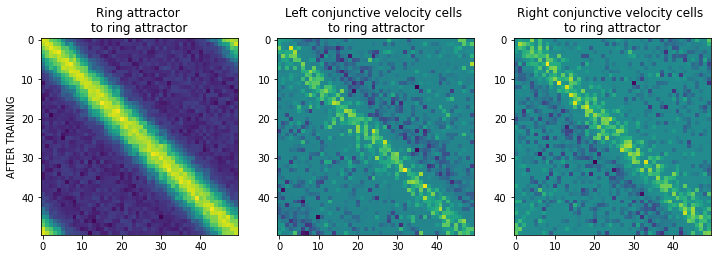

In [8]:
#pull out the weight as they were at initialisation 
w_ccl_init = RingAttractor.apical_compartment.inputs['ConjunctiveCells_left']['w_init']
w_ccr_init = RingAttractor.apical_compartment.inputs['ConjunctiveCells_right']['w_init']
w_rec_init = RingAttractor.apical_compartment.inputs['RingAttractor']['w_init']

#pull out the weights after training
w_ccl = RingAttractor.apical_compartment.inputs['ConjunctiveCells_left']['w']
w_ccr = RingAttractor.apical_compartment.inputs['ConjunctiveCells_right']['w']
w_rec = RingAttractor.apical_compartment.inputs['RingAttractor']['w']

#plot them 
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(w_rec_init)
ax[1].imshow(w_ccl_init)
ax[2].imshow(w_ccr_init)
ax[0].set_ylabel("BEFORE TRAINING")
ax[0].set_title("Ring attractor \nto ring attractor")
ax[1].set_title("Left conjunctive velocity cells \nto ring attractor")
ax[2].set_title("Right conjunctive velocity cells \nto ring attractor")

fig1, ax1 = plt.subplots(1,3,figsize=(12,4))
ax1[0].imshow(w_rec)
ax1[1].imshow(w_ccl)
ax1[2].imshow(w_ccr)
ax1[0].set_ylabel("AFTER TRAINING")
ax1[0].set_title("Ring attractor \nto ring attractor")
ax1[1].set_title("Left conjunctive velocity cells \nto ring attractor")
ax1[2].set_title("Right conjunctive velocity cells \nto ring attractor")

if save_plots == True: 
    tpl.saveFigure(fig,"PIweights_beforelearning")    
    tpl.saveFigure(fig1,"PIweights_afterlearning")

### Further analysis

In a seperate analysis (of the same network, but code not given here) we produced the following figures. 

The first shows the weight matrices before and after learning, along side a row-averaged cross section of the after-learning matrices. One can see how the theoritical hypothsis for how weights should develop in this system is correctly found by the Hebbian local learning rule (in less than 10 minutes of training!). 

In the movie we summarise an experiment where the animal is left to explore for 60 seconds. For the first 60 seconds sensory *and* top-down inouts are available. For times 30s to 60s the sensory input from the place cells are lesioned and only the velocity integration part (the top-down apical dendritic compartment) drives the soma. As can be seen, although errors accumulate, the network does a decent job at maintaining the position estimate in the total absence of sensory input. Purple shows true position of agent, blue shows position in neural manifold of peak activity. We encourage anyone intersted to replicate this very simple experiment using the above code. 

 * Proof the connectivity structure matches that of a classically define veloicty-driven path integrator CANN. 
 <img src="../images/pathint_resultsmatrices.png" width="750" align="center"> 
 
* Proof this connectivity structure can actually perform path integration
 <img src="../images/pathint_result.gif" width="750" align="center"> 


### Disclaimer: 
Please note this script is intended as a tutorial, here only to demonstrate how `RatInABox` could be used for a path integration project in continuous time and space and not as a scientific result regarding the role of hippocampus and entorhinal cortex role in path integration. 